## Import

In [238]:

import os 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import dlib

## 00.Image load

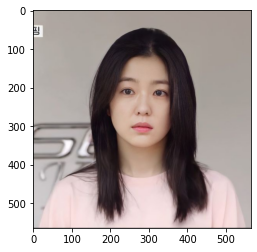

In [239]:
# 이미지 불러오기
my_image_path = 'images/face.jpg'
img_bgr = cv2.imread(my_image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 출력용 이미지 별도 보관
# 따로 보관 이유 : 바운더리를 넣고, 다시 지우기가 힘들기 때문. 즉, 바운더리해서 볼 사진 따로, 고양이 코만 넣을 사진 따로 생성
img_show = img_rgb.copy()

# 이미지 출력
plt.imshow(img_rgb) 
plt.show() 

## 00.Face boundery 생성

In [240]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 얼굴 좌표, 여러개 나올 수 있음
# 순서 : 좌 상 우 하
print(dlib_rects) 

rectangles[[(201, 160) (386, 345)]]


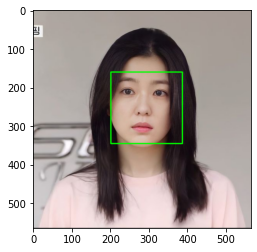

In [241]:
# 얼굴 주변 사각형 그리기
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    left = dlib_rect.left() # 왼쪽
    top = dlib_rect.top() # 위쪽
    right = dlib_rect.right() # 오른쪽
    bottom = dlib_rect.bottom() # 아래쪽

    # 얼굴 주변 사각형 그리기
    cv2.rectangle(img_rgb, (left,top), (right,bottom), (0,255,0), 2, lineType=cv2.LINE_AA)

# 이미지 출력
plt.imshow(img_rgb)
plt.show()

## 00.Face Landmark 생성

In [242]:
# 저장한 landmark 모델의 주소
model_path = 'models/shape_predictor_68_face_landmarks.dat'
# 모델 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

In [243]:
# 랜드마크 생성
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


In [244]:
# 코 좌표를 기준으로 고양이 코 넣을 위치 지정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ('코 좌표 :',landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 코 부위의 x값
    y = landmark[30][1] + dlib_rect.height()//2  # 코 부위의 y값 + 바운더리의 절반 높이 값
    w = h = dlib_rect.width() 
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

코 좌표 : (285, 256)
(x,y) : (285,349)
(w,h) : (186,186)


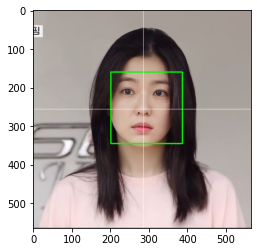

In [245]:
# 코 좌표의 (285, 256) 위치 찾기

# 이미지에 가로, 세로로 흰색 줄 넣기
line_color = (255, 255, 255)  # 흰색 (BGR 형식)

# 가로 줄 그리기
img_rgb = cv2.line(img_rgb, (0, 256), (img_rgb.shape[1], 256), line_color, thickness=1)

# 세로 줄 그리기
img_rgb = cv2.line(img_rgb, (285, 0), (285, img_rgb.shape[0]), line_color, thickness=1)

# 이미지 출력
plt.imshow(img_rgb)
plt.show()


## 00.고양이 이미지 불러오기

(186, 186, 3)


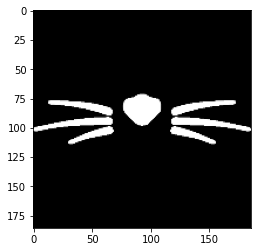

In [246]:
# 고양이 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png' 
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_COLOR) 
img_sticker = cv2.resize(img_sticker, (w,h)) 
print (img_sticker.shape) 

# 이미지 색상 반전
img_sticker = cv2.bitwise_not(img_sticker)

# 이미지 출력
plt.imshow(img_sticker) 
plt.show() 

In [247]:
# 스티커 위치 설정
refined_x = x - w // 2 
refined_y = y - h

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (192,163)


In [248]:
# 고양이가 이미지 밖에서 시작하지 않게 조정
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (192,163)


## 00.고양이 코 그리기

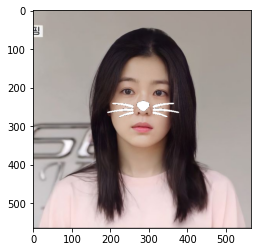

In [249]:
# 최종 고양이 코 그리기
sticker_area = img_show[
    refined_y : refined_y + img_sticker.shape[0], 
    refined_x : refined_x + img_sticker.shape[1]
]

img_show[
    refined_y : refined_y + img_sticker.shape[0], 
    refined_x : refined_x + img_sticker.shape[1]
] = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(img_show)
plt.show()

## 00.고양이 코 반투명 만들기

- 고양이 코가 '흰색'이라 티가 안난다...ㅎㅎ

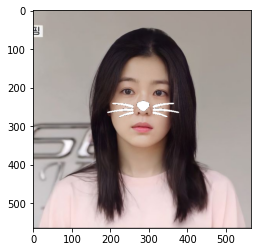

In [250]:
# 코 부분에 가중합 적용
alpha = 0.7  # 가중치 (0.0 ~ 1.0 사이 값)
img_show[
    refined_y : refined_y + img_sticker.shape[0], 
    refined_x : refined_x + img_sticker.shape[1]
] = cv2.addWeighted(sticker_area, alpha, np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8), 1-alpha, 0).astype(np.uint8)

plt.imshow(img_show)
plt.show()


## (별도) 여러명일땐 어떻게 나올려나?

- 결론 : 나쁘지 않다? 생각보다 잘 나온다

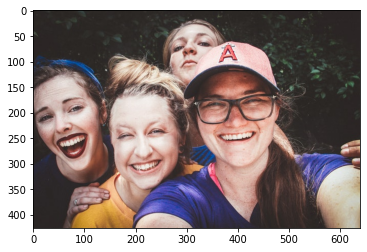

In [251]:
# 이미지 불러오기
my_image_path = 'images/faces.jpg'
img_bgr = cv2.imread(my_image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 출력용 이미지 별도 보관
# 따로 보관 이유 : 바운더리를 넣고, 다시 지우기가 힘들기 때문. 즉, 바운더리해서 볼 사진 따로, 고양이 코만 넣을 사진 따로 생성
img_show = img_rgb.copy()

# 이미지 출력
plt.imshow(img_rgb) 
plt.show() 

In [252]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 얼굴 좌표, 여러개 나올 수 있음
# 순서 : 좌 상 우 하
print(dlib_rects) 

rectangles[[(132, 184) (287, 339)], [(-22, 150) (150, 305)], [(322, 150) (476, 305)], [(265, 36) (354, 126)]]


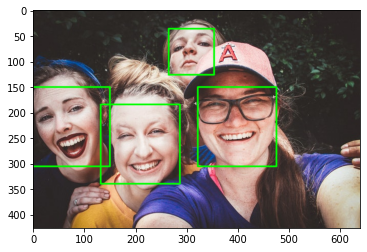

In [253]:
# 얼굴 주변 사각형 그리기
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    left = dlib_rect.left() # 왼쪽
    top = dlib_rect.top() # 위쪽
    right = dlib_rect.right() # 오른쪽
    bottom = dlib_rect.bottom() # 아래쪽

    # 얼굴 주변 사각형 그리기
    cv2.rectangle(img_rgb, (left,top), (right,bottom), (0,255,0), 2, lineType=cv2.LINE_AA)

# 이미지 출력
plt.imshow(img_rgb)
plt.show()

In [254]:
# 저장한 landmark 모델의 주소
model_path = 'models/shape_predictor_68_face_landmarks.dat'
# 모델 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

In [255]:
# 랜드마크 생성
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


코 좌표 : (216, 283)
코 좌표 : (51, 231)
코 좌표 : (397, 222)
코 좌표 : (303, 70)


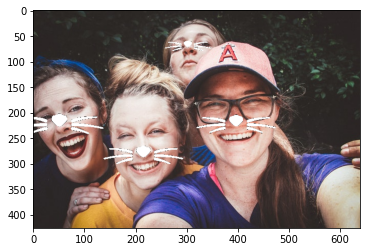

In [256]:
# 코 좌표를 기준으로 고양이 코 넣을 위치 지정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png' 
    img_sticker = cv2.imread(sticker_path, cv2.IMREAD_COLOR) 

    # 이미지 색상 반전
    img_sticker = cv2.bitwise_not(img_sticker)
    
    print ('코 좌표 :',landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 코 부위의 x값
    y = landmark[30][1] + dlib_rect.height()//2  # 코 부위의 y값 + 바운더리의 절반 높이 값
    w = h = dlib_rect.width() 
    
    img_sticker = cv2.resize(img_sticker, (w,h))  

    
    # 스티커 위치 설정
    refined_x = x - w // 2 
    refined_y = y - h

    # 고양이가 이미지 밖에서 시작하지 않게 조정
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    # 최종 고양이 코 그리기
    sticker_area = img_show[
        refined_y : refined_y + img_sticker.shape[0], 
        refined_x : refined_x + img_sticker.shape[1]
    ]

    img_show[
        refined_y : refined_y + img_sticker.shape[0], 
        refined_x : refined_x + img_sticker.shape[1]
    ] = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(img_show)
plt.show()

## (별도) 옆 얼굴은 어떻게 될까?

- 결론 : 옆 얼굴은 인식 못함

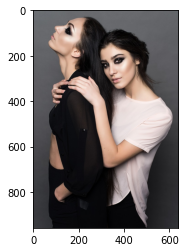

rectangles[[(270, 184) (425, 339)]]


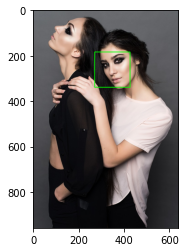

68
코 좌표 : (341, 277)


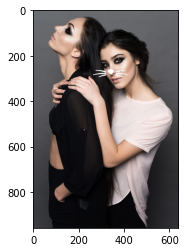

In [257]:
# 이미지 불러오기
my_image_path = 'images/face2.jpg'
img_bgr = cv2.imread(my_image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 출력용 이미지 별도 보관
# 따로 보관 이유 : 바운더리를 넣고, 다시 지우기가 힘들기 때문. 즉, 바운더리해서 볼 사진 따로, 고양이 코만 넣을 사진 따로 생성
img_show = img_rgb.copy()

# 이미지 출력
plt.imshow(img_rgb) 
plt.show() 

# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 얼굴 좌표, 여러개 나올 수 있음
# 순서 : 좌 상 우 하
print(dlib_rects) 

# 얼굴 주변 사각형 그리기
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    left = dlib_rect.left() # 왼쪽
    top = dlib_rect.top() # 위쪽
    right = dlib_rect.right() # 오른쪽
    bottom = dlib_rect.bottom() # 아래쪽

    # 얼굴 주변 사각형 그리기
    cv2.rectangle(img_rgb, (left,top), (right,bottom), (0,255,0), 2, lineType=cv2.LINE_AA)

# 이미지 출력
plt.imshow(img_rgb)
plt.show()

# 저장한 landmark 모델의 주소
model_path = 'models/shape_predictor_68_face_landmarks.dat'
# 모델 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 생성
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# 코 좌표를 기준으로 고양이 코 넣을 위치 지정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png' 
    img_sticker = cv2.imread(sticker_path, cv2.IMREAD_COLOR) 

    # 이미지 색상 반전
    img_sticker = cv2.bitwise_not(img_sticker)
    
    print ('코 좌표 :',landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 코 부위의 x값
    y = landmark[30][1] + dlib_rect.height()//2  # 코 부위의 y값 + 바운더리의 절반 높이 값
    w = h = dlib_rect.width() 
    
    img_sticker = cv2.resize(img_sticker, (w,h))  

    
    # 스티커 위치 설정
    refined_x = x - w // 2 
    refined_y = y - h

    # 고양이가 이미지 밖에서 시작하지 않게 조정
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    # 최종 고양이 코 그리기
    sticker_area = img_show[
        refined_y : refined_y + img_sticker.shape[0], 
        refined_x : refined_x + img_sticker.shape[1]
    ]

    img_show[
        refined_y : refined_y + img_sticker.shape[0], 
        refined_x : refined_x + img_sticker.shape[1]
    ] = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(img_show)
plt.show()